# Retail customer segmentation

The aim of this project is to conduct customer segmentation using a clustering algorithm. This will involve dividing a diverse customer base into smaller, homogeneous groups based on shared characteristics like demographics, behavior, or preferences. This strategy is invaluable as it enables businesses to tailor their marketing efforts, products, and services to each segment's specific needs and preferences. By doing so, companies can enhance customer satisfaction, loyalty, and profitability. Moreover, it allows for more efficient resource allocation, helping businesses focus their resources where they are most likely to yield the highest returns. Overall, customer segmentation empowers businesses to create more personalized and targeted experiences, ultimately driving better results and a competitive edge in the market.

# Scope

The dataset has been downloaded from [Kaggle](https://www.kaggle.com/code/karnikakapoor/customer-segmentation-clustering) The data contains customer information collected from a mall's membership cards.

## About the data

The features can be divided into the following four themes:

1. *People:*
* ***ID (nominal):*** Customer's unique identifier
* ***Year_birth (date):*** Birth year
* ***Education (nominal):*** Education level
* ***Marital_Status (nominal):*** Marital status
* ***Income (numerical):*** Annual household income
* ***Kidhome (numerical):*** No. of children in the household
* ***Teenhome (numerical):*** No. of teens in the household
* ***Dt_Customer (date):*** Date of customer's enrolment
* ***Recency (numerical):*** No. of days since last purchase
* ***Complain (nominal/boolean):*** Complained in the last 2 years (1/0 = yes/no)

2. *Products:*
* ***MntWines (numerical):*** Expenditure on wine in last 2 years
* ***MntFruits (numerical):*** Expenditure on fruits in the last 2 years
* ***MntMeatProducts (numerical):*** Expenditure on meat in the last 2 years
* ***MntFishProducts (numerical):*** Expenditure on fish in the last 2 years
* ***MntSweetProducts (numerical):*** Expenditure on sweets in the last 2 years
* ***MntGoldProds (numerical):*** Expenditure on gold in the last 2 years

3. *Promotion:*
* ***NumDealsPurchases (numerical):*** No. of purchases made with a discount
* ***AcceptedCmp1 (nominal/boolean):*** Accepted offer in the 1st campaign (1/0 = yes/no)
* ***AcceptedCmp2 (nominal/boolean):*** Accepted offer in the 2nd campaign (1/0 = yes/no)
* ***AcceptedCmp3 (nominal/boolean):*** Accepted offer in the 3rd campaign (1/0 = yes/no)
* ***AcceptedCmp4 (nominal/boolean):*** Accepted offer in the 4th campaign (1/0 = yes/no)
* ***AcceptedCmp5 (nominal/boolean):*** Accepted offer in the 5th campaign (1/0 = yes/no)
* ***Response (nominal/boolean):*** Accepted offer in the last campaign (1/0 = yes/no)

4. *Place:*
* ***NumWebPurchases (numerical):*** No. of purchases via website
* ***NumCataloguePurchases (numerical):*** No. of purchases via catalogue
* ***NumStorePurchases (numerical):*** No. of purchases in store
* ***NumWebVisitsMonth (numerical):*** No. of visits to website in the last month

# Data exploration

All variables will be characterised by calculating summary statistics and visualising distributions. The relationship (i.e. correlation & linearity) between variables will also be assessed.

## Dependencies

In [1]:
import sys
CONFIG_DIRECTORY = 'C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\retail-customer-segmentation\\retail-customer-segmentation'
if CONFIG_DIRECTORY not in sys.path:
    sys.path.insert(0, CONFIG_DIRECTORY)

import ast
import config
import datetime
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
import warnings
plt.style.use('seaborn-v0_8-muted')

## Import data

In [2]:
raw_df = pd.read_csv(config.file_directory('raw') + 'marketing_campaign.csv', sep ='\t')
raw_df = raw_df.drop(['Z_CostContact', 'Z_Revenue'], axis=1)
print(f"Number of records: {raw_df.shape[0]}")
raw_df.head(3)

Number of records: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   

  Dt_Customer  Recency  MntWines  ...  NumCatalogPurchases  NumStorePurchases  \
0  04-09-2012       58       635  ...                   10                  4   
1  08-03-2014       38        11  ...                    1                  2   
2  21-08-2013       26       426  ...                    2                 10   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  5             0             0             0             0   
2                  4             0             0             0             0   

   AcceptedCmp2  Complain  Response  
0             0         0         1  
1             0         0         0  
2             0         0         0  

[3 rows x 27 columns]

## Data types
* The data is heterogenous. Both numerical and categorical variables are present.
* By default, boolean and date variables have been imported as an object data type. To simplify later analyses, these data types will be updated.

In [3]:
raw_df.dtypes.value_counts()

int64      23
object      3
float64     1
Name: count, dtype: int64

In [4]:
raw_df['Dt_Customer'] = pd.to_datetime(raw_df['Dt_Customer'], format='%d-%m-%Y')
raw_df['ID'] = raw_df['ID'].astype(object)
raw_df[['Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']] = raw_df[[
    'Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].astype('bool')
raw_df.dtypes.value_counts()

int64             15
bool               7
object             3
float64            1
datetime64[ns]     1
Name: count, dtype: int64

## Missing values
* A small proportion (1%) of values in the income column (a numerical variable) are missing. Given the small proportion of records, the corresponding records will be ommitted from further analyses.

In [5]:
raw_df.isnull().sum()[(raw_df.isnull().sum() > 1)]

Income    24
dtype: int64

In [6]:
print(f"Percentage of missing values in the income column: {round(24/2440*100,2)}%")

Percentage of missing values in the income column: 0.98%


In [7]:
clean_df = raw_df.copy(deep=True)
clean_df = clean_df.dropna(axis=0, how='any')
clean_df.isnull().sum()[(clean_df.isnull().sum() > 1)]

Series([], dtype: int64)

## Summary stats and feature distributions
* Key summary statistics will be calculated for each variable. Those with low variance and therefore potentially little segmentation value will be identified.

* Histograms will be used to assess range, skewness, kurtosis and outliers for numerical variables. Bar charts will be used to assess cardinality for categorical variables.

### Date variables

#### Year of birth
* Birth year is used to calculate an approximate age based on the year the data was publised to Kaggle (2021).
* Bar charts reveal several outliers. These data points look erroneous as the customers were born at the end of the 19th century. 

In [8]:
from custom_funcs import perc_func
clean_df['Age'] = 2021 - clean_df['Year_Birth']
clean_df[['Year_Birth', 'Age']].describe()

Year_Birth          Age
count  2216.000000  2216.000000
mean   1968.820397    52.179603
std      11.985554    11.985554
min    1893.000000    25.000000
25%    1959.000000    44.000000
50%    1970.000000    51.000000
75%    1977.000000    62.000000
max    1996.000000   128.000000

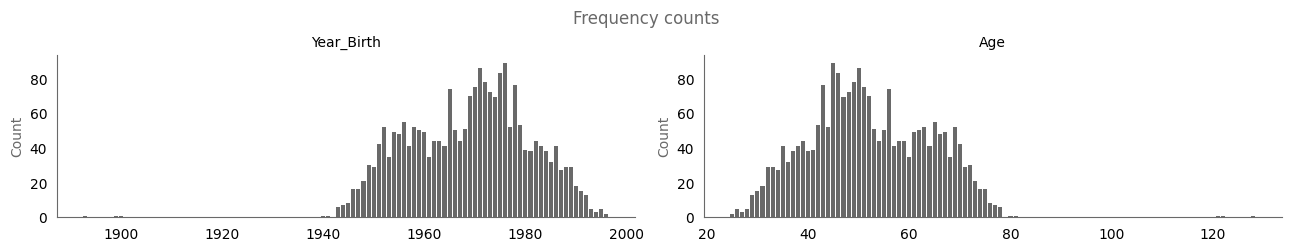

In [9]:
object_cols = ['Year_Birth', 'Age']
fig, axes = plt.subplots(
    nrows=1, ncols=2, constrained_layout=True, figsize=(6.4*2, 4.8/2))
for ax, col in zip(axes, object_cols):
    freq = perc_func(clean_df, col)
    bars = ax.bar(freq.index, freq['count'], color='dimgray')
    ax.set_ylabel('Count', fontsize=10, color='dimgray')
    ax.set_title(f"{col}", fontsize=10)
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.suptitle('Frequency counts', color='dimgray');

#### Date of enrolment
* The earliest and latest data points are 30-07-2012 and 29-06-2014. It is unclear whether data collection was occuring outside of these bounds.
  
* The distribution of enrolments over the observed time period is reasonably uniform.  As might be expected, the highest number of enrolments were therefore in 2013.

* No substantial differences in enrolments were observed for different days/months. No seasonal trends appear to be present.

In [10]:
clean_df[['Dt_Customer']].describe()

Dt_Customer
count                           2216
mean   2013-07-10 11:29:27.509025280
min              2012-07-30 00:00:00
25%              2013-01-16 00:00:00
50%              2013-07-08 12:00:00
75%              2013-12-31 00:00:00
max              2014-06-29 00:00:00

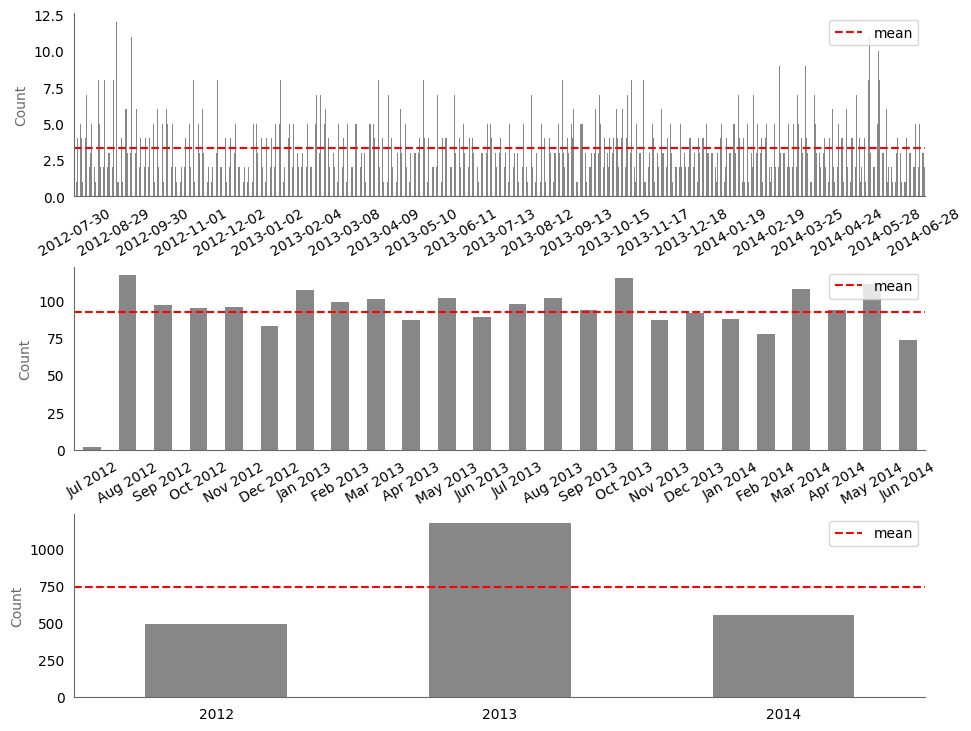

In [11]:
# Calc enrolments per day/month/year
enrols_per_day = clean_df['Dt_Customer'].groupby(clean_df['Dt_Customer']).count()
enrols_per_month = clean_df['Dt_Customer'].groupby([clean_df['Dt_Customer'].dt.year, clean_df['Dt_Customer'].dt.month]).count()
enrols_per_year = clean_df['Dt_Customer'].groupby(clean_df['Dt_Customer'].dt.year).count()

# Plot enrolments per day
fig, axes = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(6.4*1.5, 4.8*1.5))
enrols_per_day.plot.bar(ax=axes[0], color='dimgray', alpha=0.8, label='')
axes[0].axhline(enrols_per_day.mean(), linestyle='--', color='red', label='mean')
xtick_labels = axes[0].get_xticklabels()[::30]
xtick_positions = [x.get_position()[0] for x in xtick_labels]
xtick_labels = [x.get_text()[:10] for x in xtick_labels]
axes[0].set_xticks(xtick_positions, xtick_labels)
axes[0].set_xticklabels(xtick_labels, rotation=30)

# Plot enrolments per year/month
enrols_per_month.plot.bar(ax=axes[1], color='dimgray', alpha=0.8, label='')
axes[1].axhline(enrols_per_month.mean(), linestyle='--', color='red', label='mean')
xtick_labels = [item.get_text() for item in axes[1].get_xticklabels()]
xtick_labels = [ast.literal_eval(label) for label in xtick_labels]
dates = {1:'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
xtick_labels = [dates[label[1]] + " " + str(label[0]) for label in xtick_labels]
axes[1].set_xticklabels(xtick_labels, rotation=30);

# Plot enrolments per year
enrols_per_year.plot.bar(ax=axes[2], color='dimgray', alpha=0.8, label='')
axes[2].axhline(enrols_per_year.mean(), linestyle='--', color='red', label='mean')
xtick_labels = [item.get_text() for item in axes[2].get_xticklabels()]
axes[2].set_xticklabels(xtick_labels, rotation=0);

for ax in axes:
    ax.legend(loc='upper right');
    ax.set_xlabel('')
    ax.set_ylabel('Count', fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

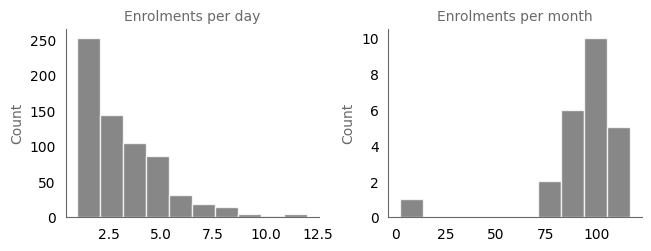

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/2))
enrols_per_day.plot.hist(ax=axes[0], color='dimgray', alpha=0.8, edgecolor ="white")
enrols_per_month.plot.hist(ax=axes[1], color='dimgray', alpha=0.8, edgecolor ="white")

axes[0].set_title('Enrolments per day', fontsize=10, color='dimgray')
axes[1].set_title('Enrolments per month', fontsize=10, color='dimgray')
for ax in axes:
    ax.set_ylabel('Count', fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

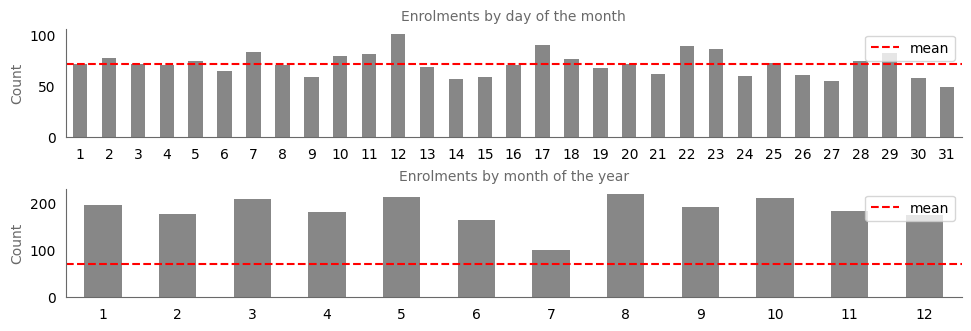

In [13]:
enrols_by_day = clean_df['Dt_Customer'].groupby(clean_df['Dt_Customer'].dt.day).count()
enrols_by_month = clean_df['Dt_Customer'].groupby(clean_df['Dt_Customer'].dt.month).count()

fig, axes = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(6.4*1.5, 4.8/1.5))
enrols_by_day.plot.bar(ax=axes[0], color='dimgray', alpha=0.8, label='')
axes[0].axhline(enrols_by_day.mean(), linestyle='--', color='red', label='mean')
enrols_by_month.plot.bar(ax=axes[1], color='dimgray', alpha=0.8, label='')
axes[1].axhline(enrols_by_day.mean(), linestyle='--', color='red', label='mean')

axes[0].set_title('Enrolments by day of the month', fontsize=10, color='dimgray')
axes[1].set_title('Enrolments by month of the year', fontsize=10, color='dimgray')
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('Count', fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False, rotation=0)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.legend(loc='upper right')

### Nominal variables

* The ID field has the highest cardinality. The number of unique values corresponds to the total number of records (2,216). This shows no duplicate values are present.

* The bar chart for Education reveals seperate classifications for Masters and 2n Cycle studies (graduate level or master's level). These will be aggregated later.

* The cardinality of the marital status field is reasonbly high (8). Furthermore, three of the categories each contain roughly 0.1% of records. These will be aggregated later. 

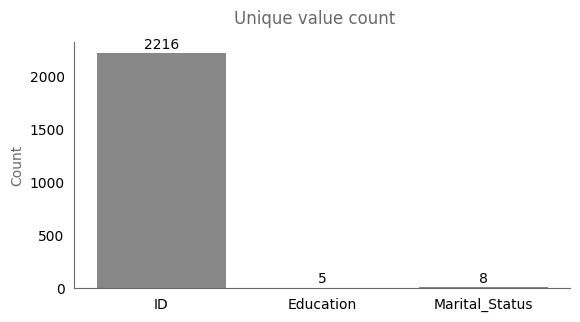

In [14]:
object_nunique = clean_df.select_dtypes(include=object).nunique()
fig, axes = plt.subplots(figsize=(6.4, 4.8/1.5))
bars = axes.bar(object_nunique.index, object_nunique.values, color='dimgray', alpha=0.8)
axes.bar_label(bars, padding=1);
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
fig.suptitle('Unique value count', color='dimgray');

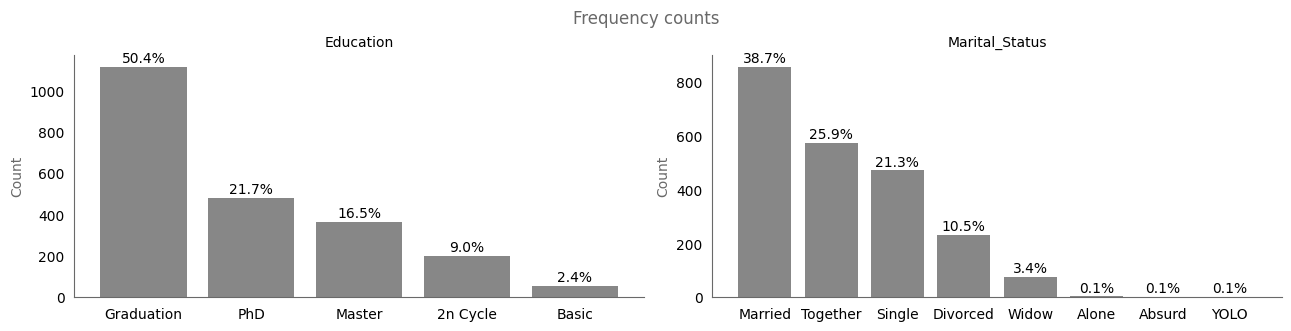

In [15]:
object_cols = ['Education', 'Marital_Status']
fig, axes = plt.subplots(
    nrows=1, ncols=2, constrained_layout=True, figsize=(6.4*2, 4.8/1.5))
for ax, col in zip(axes, object_cols):
    freq = perc_func(clean_df, col)
    bar_labels = [str(x)+'%' for x in freq['perc'].values]
    bars = ax.bar(freq.index, freq['count'], color='dimgray', alpha=0.8)
    ax.bar_label(bars, bar_labels, padding=1)
    ax.set_ylabel('Count', fontsize=10, color='dimgray')
    ax.set_title(f"{col}", fontsize=10)
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.suptitle('Frequency counts', color='dimgray');

### Boolean variables

* For both the Complain and AcceptedCmp 2 features, the majority of records are classified as No. This suggests, these fields will have little value for segmentation.

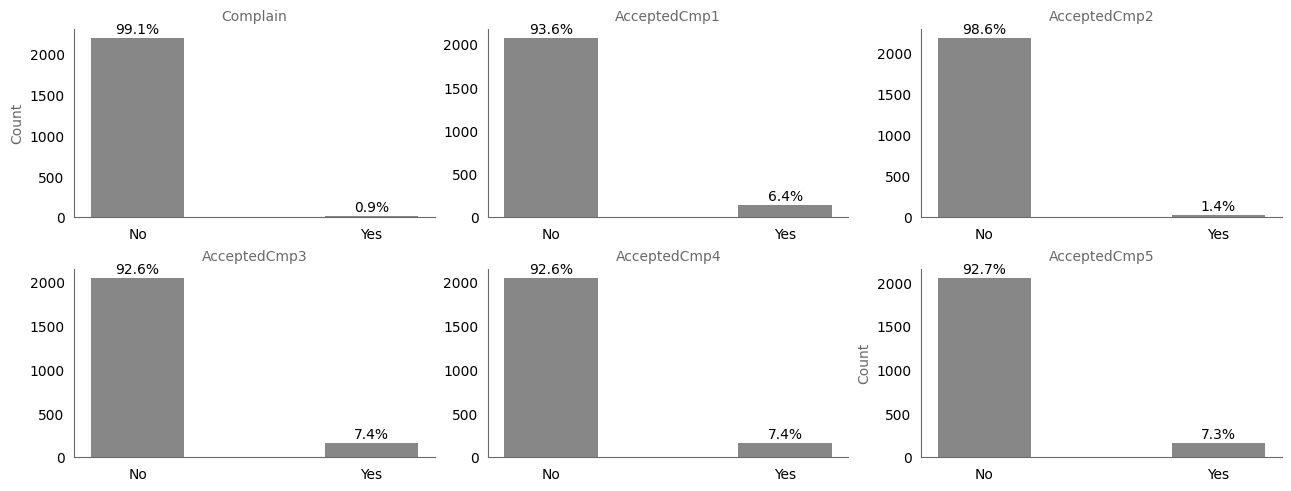

In [16]:
bool_cols = ['Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

fig, axes = plt.subplots(
    nrows=2, ncols=3, constrained_layout=True, figsize=(6.4*2, 4.8))
axes = axes.flatten()
axes[0].set_ylabel('Count', fontsize=10, color='dimgray')
axes[5].set_ylabel('Count', fontsize=10, color='dimgray')

for ax, col in zip(axes, bool_cols):
    freq = perc_func(clean_df, col)
    bar_labels = [str(x) + '%' for x in freq['perc'].values]
    bars = ax.bar(freq.index, freq['count'], color='dimgray', alpha=0.8, width=0.4)
    xtick_positions = [0, 1]
    xtick_labels = ['No', 'Yes']
    ax.bar_label(bars, bar_labels, padding=1)
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_xticks(xtick_positions, xtick_labels)
    ax.set_title(f"{col}", fontsize=10, color='dimgray')

### Numerical variables

#### People features
* The histogram for annual household income highlights the presence of outliers.

* The breakdown of the number of kids and teens at home shows the majority of families have either 0 or 1 child. Given the low proportion of 2 child families, a new is_parent boolean variable will be created and the Kidhome and Teenhome features dropped. This will help reduce dimensionality.

* The histogram for no. of days since last purchase (i.e. recency) reveals a uniform distribution.

In [17]:
num_cols = ['Income', 'Kidhome', 'Teenhome', 'Recency']
clean_df[num_cols].describe()

Income      Kidhome     Teenhome      Recency
count    2216.000000  2216.000000  2216.000000  2216.000000
mean    52247.251354     0.441787     0.505415    49.012635
std     25173.076661     0.536896     0.544181    28.948352
min      1730.000000     0.000000     0.000000     0.000000
25%     35303.000000     0.000000     0.000000    24.000000
50%     51381.500000     0.000000     0.000000    49.000000
75%     68522.000000     1.000000     1.000000    74.000000
max    666666.000000     2.000000     2.000000    99.000000

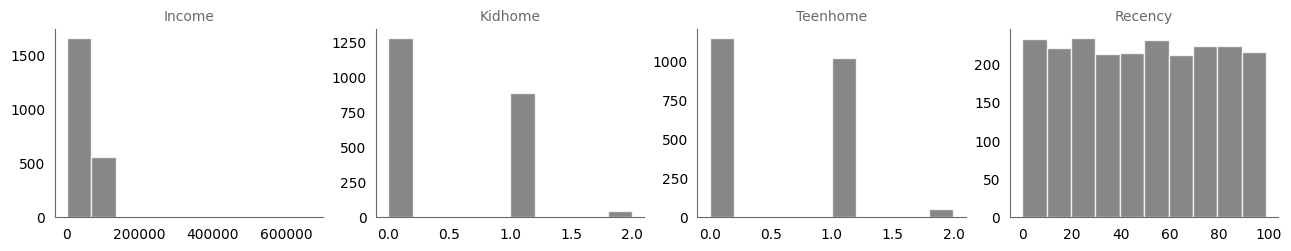

In [18]:
fig, axes = plt.subplots(
    nrows=1, ncols=4, constrained_layout=True, figsize=(6.4*2, 4.8/2))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    bars = ax.hist(clean_df[col], color='dimgray', alpha=0.8, edgecolor ="white")
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

#### Products
* A power law distribution is observed for expenditure across each of the different product types. This means the distributions are heavily skewed and non-normal.
* No outliers are obvious. 

In [19]:
num_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
clean_df[num_cols].describe()

MntWines    MntFruits  MntMeatProducts  MntFishProducts  \
count  2216.000000  2216.000000      2216.000000      2216.000000   
mean    305.091606    26.356047       166.995939        37.637635   
std     337.327920    39.793917       224.283273        54.752082   
min       0.000000     0.000000         0.000000         0.000000   
25%      24.000000     2.000000        16.000000         3.000000   
50%     174.500000     8.000000        68.000000        12.000000   
75%     505.000000    33.000000       232.250000        50.000000   
max    1493.000000   199.000000      1725.000000       259.000000   

       MntSweetProducts  MntGoldProds  
count       2216.000000   2216.000000  
mean          27.028881     43.965253  
std           41.072046     51.815414  
min            0.000000      0.000000  
25%            1.000000      9.000000  
50%            8.000000     24.500000  
75%           33.000000     56.000000  
max          262.000000    321.000000

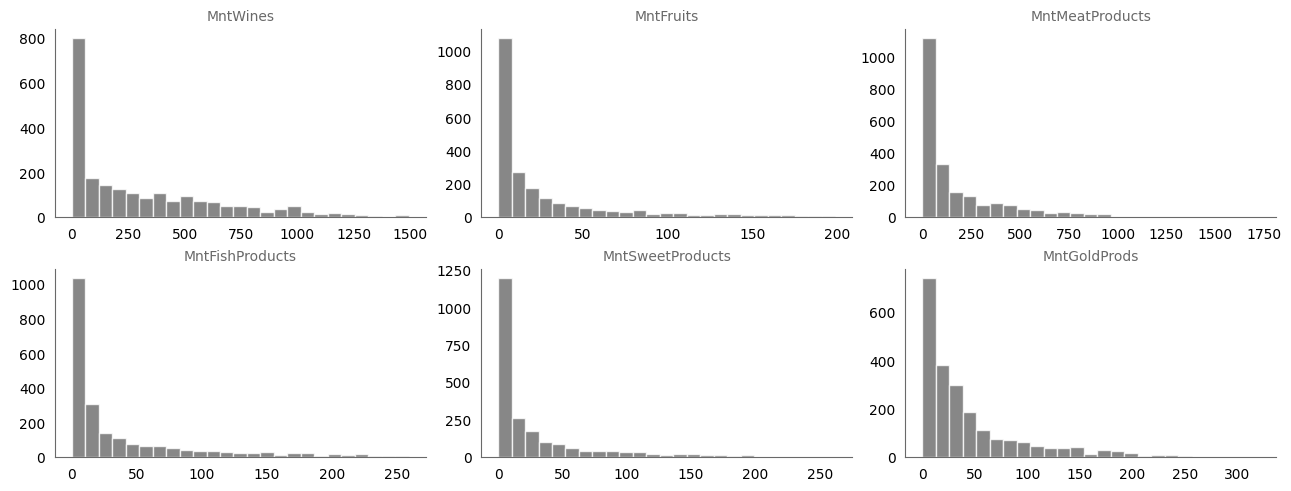

In [20]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, constrained_layout=True, figsize=(6.4*2, 4.8))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    bars = ax.hist(clean_df[col], bins=25, color='dimgray', alpha=0.8, edgecolor='white')
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

#### Promotion & place
* All variables contain count data.
* Each of the distributions is non-normal. With the exception of web visits per month, they appear Poisson like. However, it should be noted the count data is collected for each customer over varying time scales. This violates a constraint of the Poisson distribution.
* The distribution of the number of visits per month appears truncated. 
* No outliers appear to be present.

In [21]:
num_cols = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
clean_df[num_cols].describe()

NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
count        2216.000000      2216.000000          2216.000000   
mean            2.323556         4.085289             2.671029   
std             1.923716         2.740951             2.926734   
min             0.000000         0.000000             0.000000   
25%             1.000000         2.000000             0.000000   
50%             2.000000         4.000000             2.000000   
75%             3.000000         6.000000             4.000000   
max            15.000000        27.000000            28.000000   

       NumStorePurchases  NumWebVisitsMonth  
count        2216.000000        2216.000000  
mean            5.800993           5.319043  
std             3.250785           2.425359  
min             0.000000           0.000000  
25%             3.000000           3.000000  
50%             5.000000           6.000000  
75%             8.000000           7.000000  
max            13.000000          20.000000

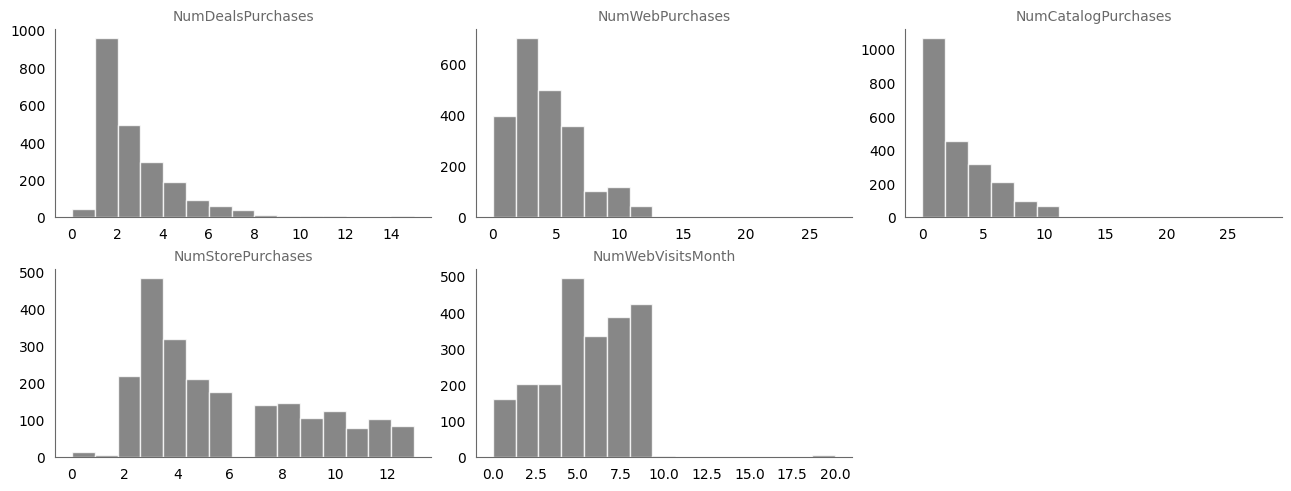

In [22]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, constrained_layout=True, figsize=(6.4*2, 4.8))
axes = axes.flatten()
for ax, col in zip(axes, num_cols):
    bars = ax.hist(clean_df[col], bins=15, color='dimgray', alpha=0.8, edgecolor='white')
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[5])

## Correlation

### Numerical-numerical
* Spearman's rank was used to assess the relationship between numerical variables. This gives a correlation coefficient between -1 and 1.
  
* It is a non-parametric test, meaning it does not assume any underlying data distribution. This was important as all numerical variables exhibited non-Normal distributions. Furthermore, a matrix of scatter plots revealed non-linear relationships between multiple features.

In [23]:
# Convert timestamp object to integerclean_df['int_dt_Customer'] = pd.to_numeric(clean_df['Dt_Customer'])

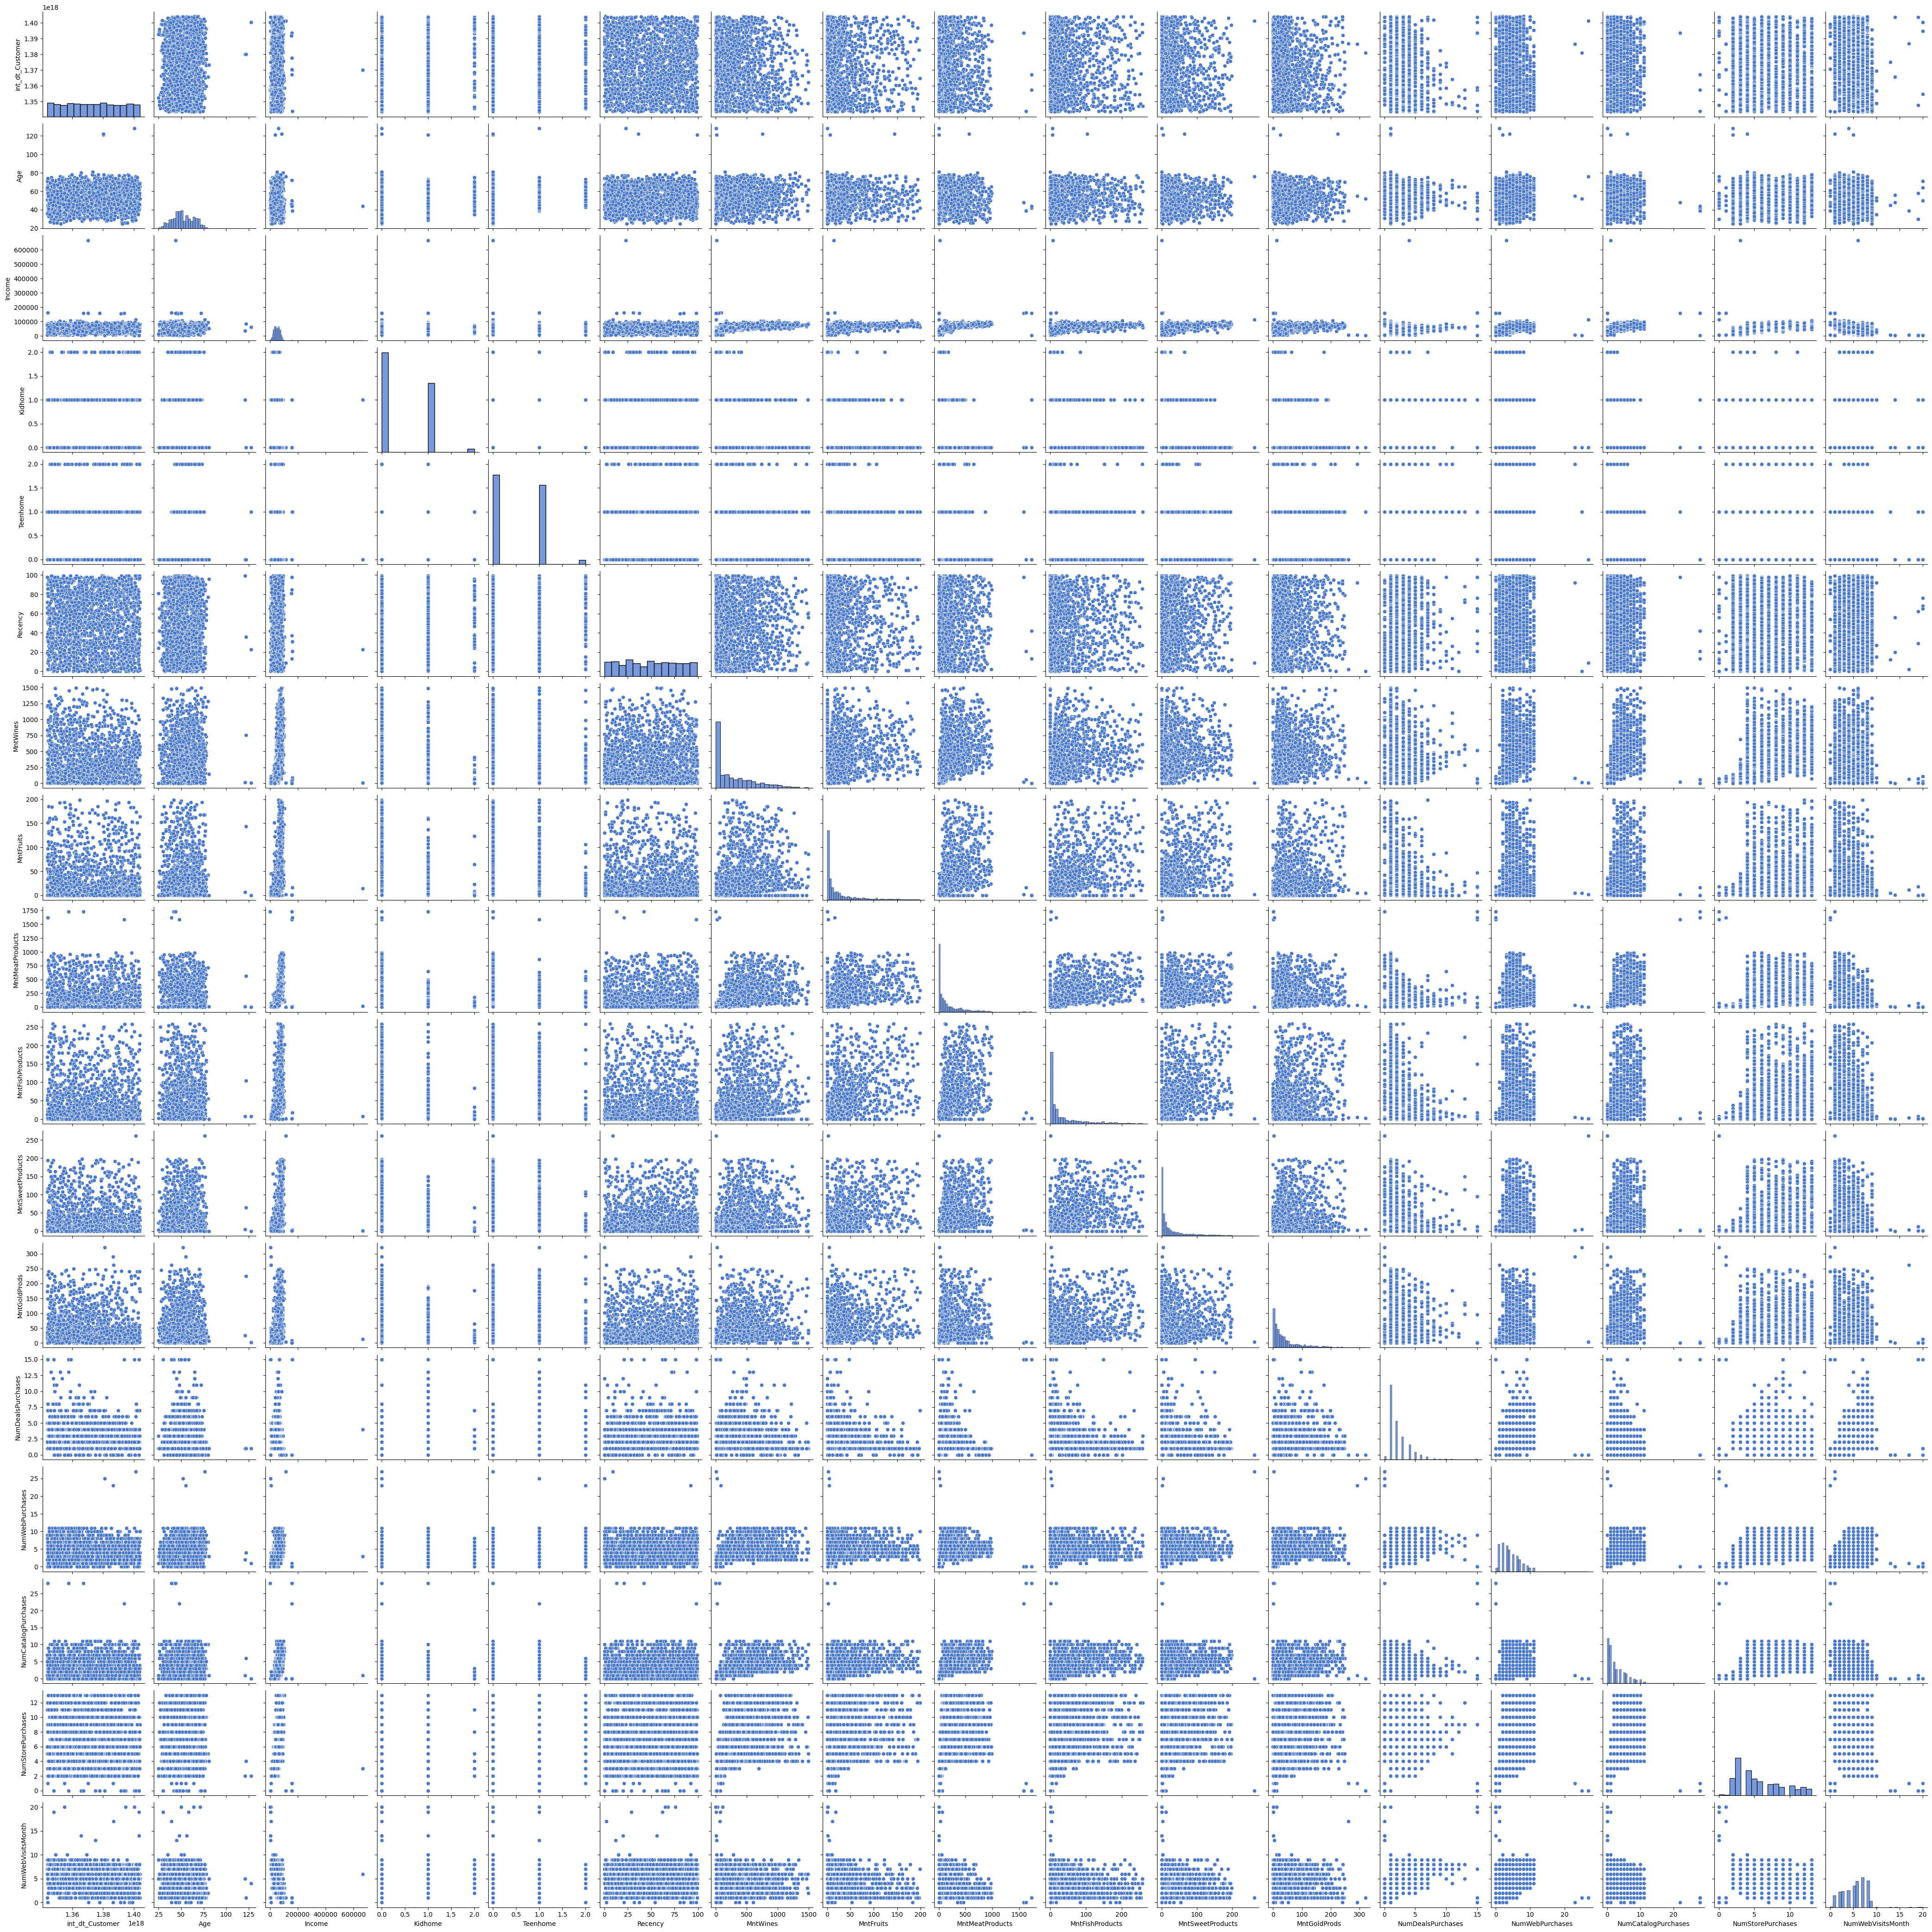

In [24]:
# Matrix of scatter plots
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

num_cols = ['int_dt_Customer', 'Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
            'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
sns.pairplot(clean_df[num_cols])

* A heatmap displaying Spearman's rank correlation coefficients is shown below.

* This heatmap shows expenditure across different types of product is highly correlated. It also shows the recency feature is not correlated with any other variable. Similarly, the date of enrolment, Age, Teenhome and NumDealsPurchases variables appear to offer little value for segmentation.

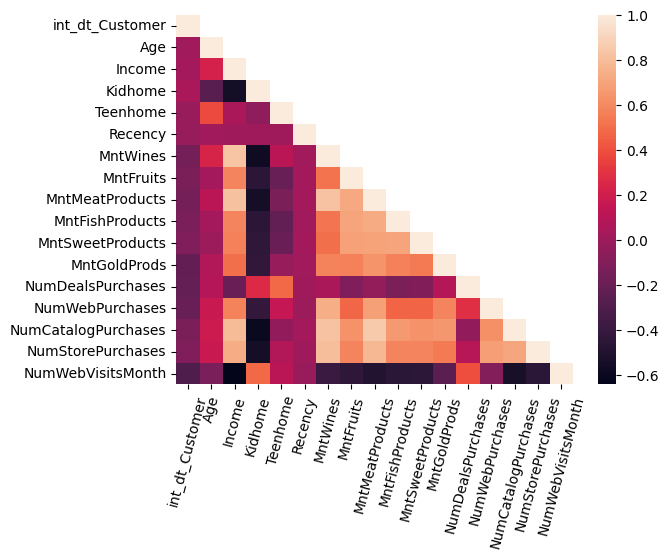

In [25]:
spearmans_corr = clean_df[num_cols].corr(method='spearman')
num_mask = np.tril(spearmans_corr) == 0

fig, axes = plt.subplots(figsize=(6.4, 4.8))
sns.heatmap(spearmans_corr, mask=num_mask, ax=axes)
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

### Categorical-categorical
* Cramer's V was used to assess bivariate associations between nominal variables. This is a non-parametric test, meaning it does not assume any underlying data distribution. It gives a value between 0 and +1.
  
* A heatmap displaying the resultant scores is shown below. This indicates all bivariate associations are relatively weak. Multiple variables are not correlated with any other feature (e.g. Marital status and Education).

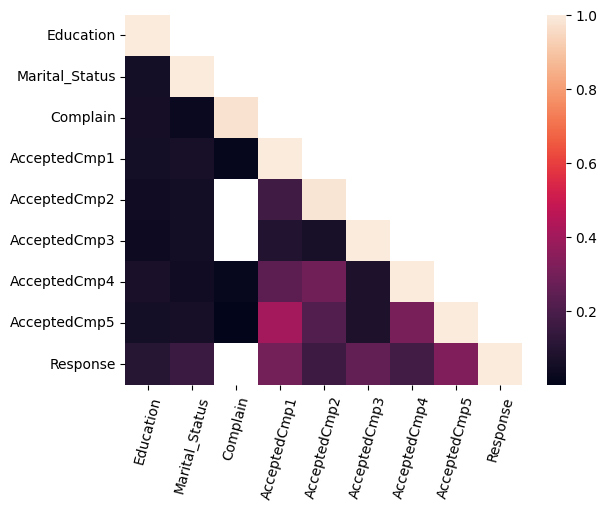

In [26]:
from custom_funcs import cramers_v

object_cols = ['Education', 'Marital_Status', 'Complain', 'AcceptedCmp1',
               'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
cramersv_corr = pd.DataFrame([[(row, col) for row in object_cols]
                        for col in object_cols], columns=object_cols, index=object_cols)
cramersv_corr = cramersv_corr.map(lambda x: cramers_v(x, df=clean_df))
cat_mask = np.tril(cramersv_corr) == 0

fig, axes = plt.subplots(figsize=(6.4, 4.8))
sns.heatmap(cramersv_corr, mask=cat_mask, ax=axes)
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

### Categorical-numerical

* One way ANOVA was used to assess the relationship between categorical and numerical variables. This determines the statistical significance of any differences in the mean of the numerical variable across different categories.
  
* A heatmap displaying the resultant p-values is shown below. This heatmap highlights multiple p-values below the 5% significance level (e.g. income and education). It also shows the recency and complain categorical variables do not significantly impact the mean value of any numerical variable. Similarly the date of enrolment feature appears to vary significantly with three fields (Education, Complain and AcceptedCmp1).

Note: One way ANOVA assumes normality. As shown earlier, this criterion is violated. However, several studies have shown one way ANOVA is not severely affected by skewness and kurtosis.

In [27]:
# from custom_funcs import point_bs
# pbs_corr = pd.DataFrame([[(row, col) for col in num_cols]
#                         for row in bool_cols], columns=num_cols, index=bool_cols)
# pbs_corr = pbs_corr.map(lambda x: point_bs(x, df=clean_df))

# fig, axes = plt.subplots(figsize=(6.4, 4.8))
# sns.heatmap(pbs_corr, ax=axes)
# xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
# axes.set_xticklabels(xtick_labels, rotation=75);

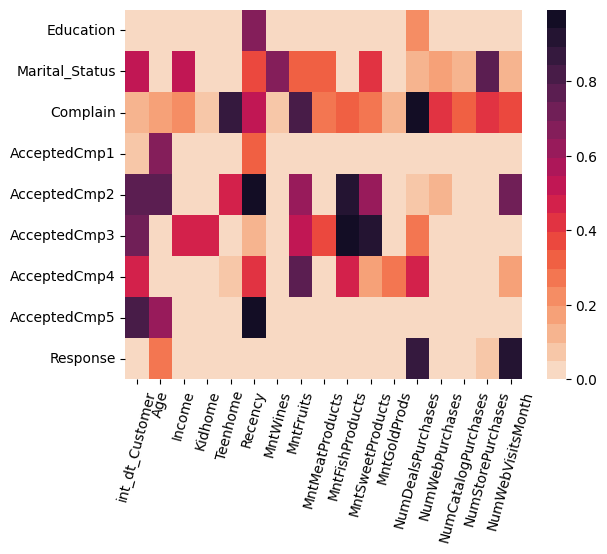

In [28]:
from scipy.stats import f_oneway
from custom_funcs import oneway_anova

anova_corr = pd.DataFrame([[(row, col) for col in num_cols]
                        for row in object_cols], columns=num_cols, index=object_cols)
anova_corr = anova_corr.map(lambda x: oneway_anova(x, df=clean_df))

fig, axes = plt.subplots(figsize=(6.4, 4.8))
sns.heatmap(anova_corr, ax=axes, cmap=sns.color_palette("rocket_r", 20))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

# Data cleansing

* No duplicate records are present in the data.

* No further missing values are present in the data.

* The record responsible for the outlier in the income variable will be removed.

* The records responsible for the outliers in the birth year variable will be removed.

* The cardinality of the marital status variable will be reduced by combining the Alone, YOLO and Absurd entries in a new other category.

* The cardinality of the education variable will be reduced by combining the 2n cycle and Master categories.

In [29]:
# Removal of outliers
clean_df = clean_df.loc[(clean_df['Income'] > 200000)==False]
clean_df = clean_df.loc[(clean_df['Year_Birth'] < 1920)==False]
clean_df = clean_df.reset_index(drop=True)
print(f"Number of records: {raw_df.shape[0]}")

Number of records: 2240


In [30]:
# Aggregation of education and marital status
clean_df.loc[clean_df['Education'] == '2n Cycle', 'Education'] = 'Master'
clean_df.loc[clean_df['Marital_Status'] == 'Alone', 'Marital_Status'] = 'Other'
clean_df.loc[clean_df['Marital_Status'] == 'Absurd', 'Marital_Status'] = 'Other'
clean_df.loc[clean_df['Marital_Status'] == 'YOLO', 'Marital_Status'] = 'Other'

# Feature engineering

The below steps are conducted.

***Dimensionality reduction***

* The following variables are added together to give a total_expenditure variable: MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts and MntGoldProds.
  
* The Kidhome and Teenhome variables are combined to create a new is_parent boolean variable.

* The following variables are then dropped: Dt_Customer, Recency, Kidhome, Teenhome, AcceptedCmp2, AcceptedCmp3, AcceptedCmp4, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts and MntGoldProds.

***Transformations***

* All nominal variables are one hot encoded.
  
* All boolean variables are label encoded (True=1, False=0).

* All numerical variables will be quantile transformed to a normal distribution.

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
eng_df = pd.DataFrame()

# Dimensionality reduction
clean_df['total_spend'] = clean_df[['MntWines', 'MntFruits', 'MntMeatProducts',
                            'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
eng_df['is_parent'] = clean_df.apply(lambda row: 1 if row['Kidhome'] + row['Teenhome'] == 2 else 0, axis=1)

# One hot encoding
eng_df = eng_df.join(pd.get_dummies(clean_df['Education'], prefix='Education', dtype=int))
eng_df = eng_df.join(pd.get_dummies(clean_df['Marital_Status'], prefix='Marital_Status', dtype=int))

# Label encoding
le = LabelEncoder()
eng_df = eng_df.join(clean_df[['AcceptedCmp1', 'AcceptedCmp5']].apply(le.fit_transform))

# Quantile transformations
cols = ['Age', 'Income', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'total_spend']
qt = QuantileTransformer(output_distribution='normal')
q_features = qt.fit_transform(clean_df[cols])
eng_df = eng_df.join(pd.DataFrame(q_features, columns=[c + '_qt' for c in cols]))
eng_df.head()

Empty DataFrame
Columns: [Education_Basic, Education_Graduation, Education_Master, Education_PhD, Marital_Status_Divorced, Marital_Status_Married, Marital_Status_Other, Marital_Status_Single, Marital_Status_Together, Marital_Status_Widow, AcceptedCmp1, AcceptedCmp5, Age_qt, Income_qt, NumDealsPurchases_qt, NumWebPurchases_qt, NumCatalogPurchases_qt, NumStorePurchases_qt, NumWebVisitsMonth_qt, total_spend_qt]
Index: []

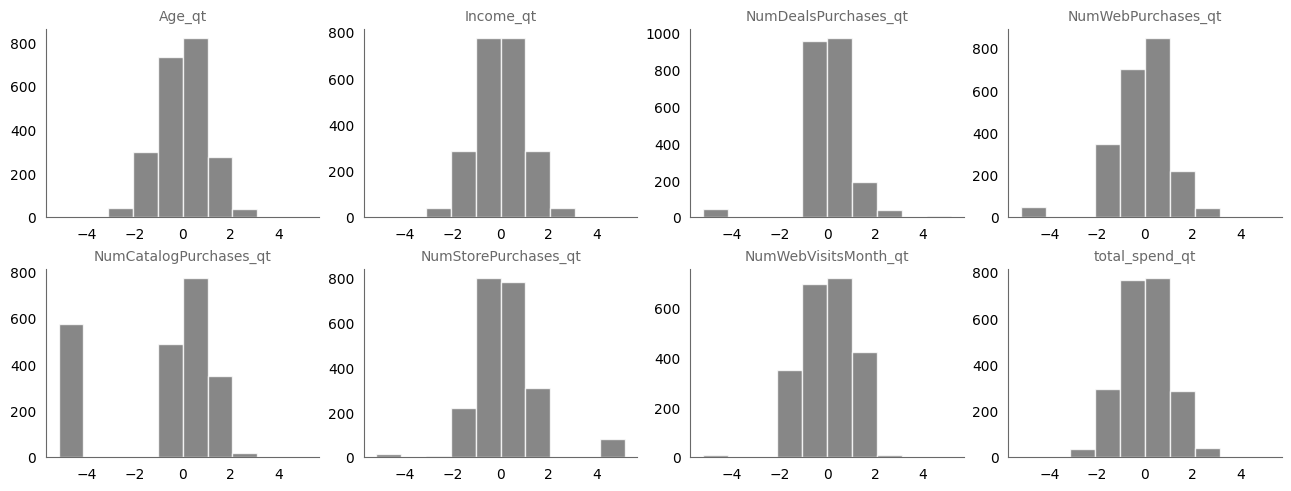

In [32]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, constrained_layout=True, figsize=(6.4*2, 4.8))
axes = axes.flatten()
for ax, col in zip(axes, list(eng_df.filter(regex='_qt', axis=1).columns)):
    bars = ax.hist(eng_df[col], color='dimgray', alpha=0.8, edgecolor ="white")
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

***PCA***

* To further reduce dimensionality, PCA is applied to the transformed dataset.

# Export data

In [39]:
clean_df.to_csv(config.file_directory('cleaned') + 'cleaned_df.csv')
eng_df.to_csv(config.file_directory('cleaned') + 'engineered_df.csv')